# Scraping for, Storing, and Exploring New York City Comedy Shows
***
***

As a big fan of stand-up comedy, I found myself frustrated at the design of the Comedy Cellar's website and the lack of central lists of shows going on in New York City; apart from bigger shows which are usually listed on such sites as Ticketmaster, show information is only listed on individual comedy club websites.

I was inspired to assemble the Comedy Cellar's shows, after interacting with their website. Users choose a date from a dropdown menu and it shows  the headlines for all of the shows that night, but then it requires the user to click on each headline individually to reveal the shows full information.  For each page this could require a user to click upto about ten times to show all desired information.

The goal of this project was to both include the show information for the Comedy Cellar in an easily queryable format, and to store show information for multiple clubs in one database.  Currently I have successfully scraped for shows from the Comedy Cellar, The Stand NYC, and Carolines, with the possibility of adding more clubs in the future.  The shows were scraped for using BeautifulSoup on December 16, 2017.

I chose MongoDB to store the shows, since it has a flexible schema and not all shows had values for all fields, and it would be better suited to storing array fields than SQL.

## Load in the Data
***

In [1]:
import pymongo
from pymongo import MongoClient
from pprint import pprint
import json
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
client = MongoClient('localhost:27017')
db = client['comedy']
coll = db.shows

In [3]:
all_shows = []

# Import all shows into the database
with open('cellar_shows.json', 'r') as f_cellar, \
     open('the_stand_shows.json', 'r') as f_stand, \
     open('carolines_shows.json', 'r') as f_carolines:
     
    cellar_shows = json.load(f_cellar)
    stand_shows = json.load(f_stand)
    carolines_shows = json.load(f_carolines)
     
    all_shows = cellar_shows + stand_shows + carolines_shows
    
    # Convert dates and times from strings to datetime objects
    for d in all_shows:
        d['date'] = datetime.strptime(d['date'], '%B %d, %Y')         
        for key, val in d['time'].items():
            d['time'][key] = datetime.strptime(val, '%B %d, %Y %I:%M %p')
        coll.insert_one(d)

## Explore the Data
***

### Number of shows

In [4]:
coll.find().count()

190

### Show one record

In [5]:
pprint(coll.find_one())

{'_id': ObjectId('5a45a2e48b602df3b9c0a10a'),
 'acts': [{'name': 'Cipha Sounds', 'type': 'MC'},
          {'name': 'Gregg Rogell', 'type': 'performer'},
          {'name': 'Lynne Koplitz', 'type': 'performer'},
          {'name': 'Keith Robinson', 'type': 'performer'},
          {'name': 'Nick Griffin', 'type': 'performer'},
          {'name': 'Andy Tranelli', 'type': 'performer'},
          {'name': 'Greer Barnes', 'type': 'performer'}],
 'date': datetime.datetime(2017, 12, 16, 0, 0),
 'date_str': 'December 16, 2017',
 'day': 'Saturday',
 'location': 'Comedy Cellar - MacDougal Street',
 'price': 24.0,
 'ticket_link': 'http://www.comedycellar.com/reservation/?showid=1513468800',
 'time': {'show_time': datetime.datetime(2017, 12, 16, 19, 0)},
 'time_str': {'show_time': '7:00 pm'}}


### Number of shows by date

In [6]:
res = list(coll.aggregate([
        {'$group': {'_id': {'date': '$date'},
                    'count': {'$sum': 1}}},
        {'$sort': {'_id': 1}}
]))

for r in res[:10]:
    pprint(r)

{'_id': {'date': datetime.datetime(2017, 12, 16, 0, 0)}, 'count': 14}
{'_id': {'date': datetime.datetime(2017, 12, 17, 0, 0)}, 'count': 11}
{'_id': {'date': datetime.datetime(2017, 12, 18, 0, 0)}, 'count': 6}
{'_id': {'date': datetime.datetime(2017, 12, 19, 0, 0)}, 'count': 12}
{'_id': {'date': datetime.datetime(2017, 12, 20, 0, 0)}, 'count': 10}
{'_id': {'date': datetime.datetime(2017, 12, 21, 0, 0)}, 'count': 10}
{'_id': {'date': datetime.datetime(2017, 12, 22, 0, 0)}, 'count': 5}
{'_id': {'date': datetime.datetime(2017, 12, 23, 0, 0)}, 'count': 6}
{'_id': {'date': datetime.datetime(2017, 12, 24, 0, 0)}, 'count': 3}
{'_id': {'date': datetime.datetime(2017, 12, 25, 0, 0)}, 'count': 2}


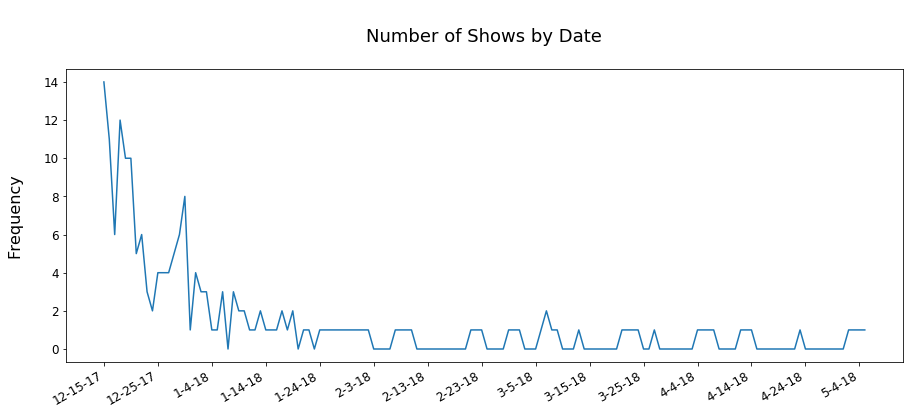

In [7]:
dates = []
counts = []
for s in res:
    dates.append(s['_id']['date'])
    counts.append(s['count'])
    
# Load dates and counts into dataframe and resample the index to include any missing days
df = pd.DataFrame({'count': counts},
                   index = dates)
df = df.resample('D', closed='right').sum().fillna(0)

date_strings = [dt.strftime("%-m-%-d-%y") for dt in df.index]

# Plot the number of shows by date
fig, ax = plt.subplots(1, 1, figsize = (15,6))

plt.plot(range(len(df.index)), df['count'])

plt.xticks(range(0, len(date_strings), 10), date_strings[::10])
plt.ylabel('Frequency\n', fontsize=16)
plt.title("\nNumber of Shows by Date\n", fontsize=18)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
fig.autofmt_xdate()

plt.show()

In [8]:
list(coll.aggregate([
        {'$match': {'date': {'$gt' : datetime(2018, 1, 16)}}},
        {'$group': {'_id': '$location',
                    'count': {'$sum': 1}}},
        {'$sort': {'count': -1}}
]))

[{'_id': 'Carolines', 'count': 51}]

After about a month after the shows were scraped for there are much fewer shows and a significant number of dates that have no scheduled shows.  Carolines is the only comedy club in the dataset that has shows scheduled more than a month in advance.
Moreover, it has a significant number of shows scheduled after January 16th.

### Number of shows by day of the week

In [9]:
res = coll.aggregate([
        {'$group': {'_id': '$day',
                    'count': {'$sum': 1}}},
        {'$sort': {'count': -1}}
])

day_counts = []
for r in res:
    pprint(r)
    day_counts.append(r)

{'_id': 'Saturday', 'count': 40}
{'_id': 'Sunday', 'count': 33}
{'_id': 'Thursday', 'count': 31}
{'_id': 'Tuesday', 'count': 27}
{'_id': 'Wednesday', 'count': 24}
{'_id': 'Friday', 'count': 23}
{'_id': 'Monday', 'count': 12}


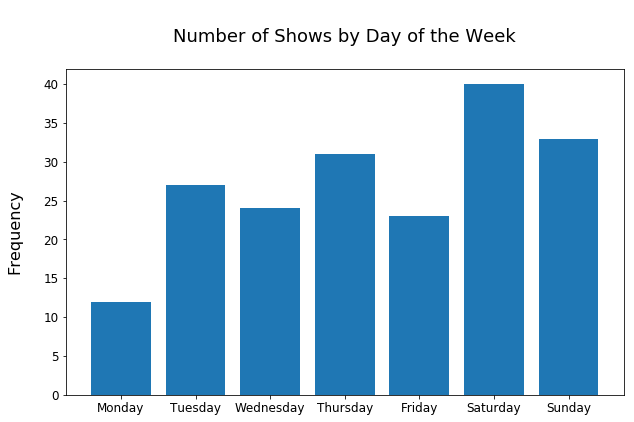

In [10]:
# Plot the number of shows by day of week
SORT_ORDER = {'Monday': 0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 
              'Friday':4, 'Saturday':5, 'Sunday':6}
sorted_day_counts = sorted(day_counts, key=lambda k: SORT_ORDER[k['_id']])

days = []
counts = []
for s in sorted_day_counts:
    days.append(s['_id'])
    counts.append(s['count'])

fig, ax  = plt.subplots(1, 1, figsize = (10,6))

plt.bar(range(len(days)), counts)
plt.xticks(range(len(days)), days)
plt.ylabel('Frequency\n', fontsize=16)
plt.title("\nNumber of Shows by Day of the Week\n", fontsize=18)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)

plt.show()

It makes sense that Saturday would have the most shows scheduled and Monday would have the least.  It was surprising to me that Sunday would have more shows than Friday, although a larger sample size could reveal this to be atypical.

### Number of shows by show time

In [11]:
res = list(coll.aggregate([
        {'$group': {'_id': '$time.show_time',
                    'count': {'$sum': 1}}},
        {'$sort': {'_id': 1}}
]))

for r in res[:10]:
    print(r)

{'_id': datetime.datetime(2017, 12, 16, 0, 0), 'count': 1}
{'_id': datetime.datetime(2017, 12, 16, 0, 15), 'count': 1}
{'_id': datetime.datetime(2017, 12, 16, 16, 0), 'count': 1}
{'_id': datetime.datetime(2017, 12, 16, 17, 45), 'count': 1}
{'_id': datetime.datetime(2017, 12, 16, 19, 0), 'count': 1}
{'_id': datetime.datetime(2017, 12, 16, 19, 15), 'count': 1}
{'_id': datetime.datetime(2017, 12, 16, 19, 30), 'count': 1}
{'_id': datetime.datetime(2017, 12, 16, 20, 0), 'count': 1}
{'_id': datetime.datetime(2017, 12, 16, 20, 45), 'count': 1}
{'_id': datetime.datetime(2017, 12, 16, 21, 15), 'count': 1}


In [12]:
# Load query results into a dataframe
df = pd.DataFrame(res)
df.columns = ['time', 'count']
df.head()

,time,count
0,2017-12-16 00:00:00,1
1,2017-12-16 00:15:00,1
2,2017-12-16 16:00:00,1
3,2017-12-16 17:45:00,1
4,2017-12-16 19:00:00,1


In [13]:
# resample the index so that there are entries every 15 minutes
df = df.resample('15Min', on='time').sum().fillna(0)
df.reset_index(level=0, inplace=True)
df.head()

,time,count
0,2017-12-16 00:00:00,1.0
1,2017-12-16 00:15:00,1.0
2,2017-12-16 00:30:00,0.0
3,2017-12-16 00:45:00,0.0
4,2017-12-16 01:00:00,0.0


In [14]:
# Only get the time part from the datetime objects
df['time'] = df['time'].apply(datetime.time)
df.head()

,time,count
0,00:00:00,1.0
1,00:15:00,1.0
2,00:30:00,0.0
3,00:45:00,0.0
4,01:00:00,0.0


In [15]:
# Group all of the same times together
grouped = df.groupby('time').sum().reset_index()
grouped['time'] = grouped['time'].apply(lambda x: str(x)[:-3]) # do not include seconds
grouped.head()

,time,count
0,00:00,6.0
1,00:15,1.0
2,00:30,2.0
3,00:45,0.0
4,01:00,0.0


In [16]:
# Sort the times so as to not include the middle chunk of the day with
# no shows and put times after midnight at the end of the day
df_plot = grouped.iloc[np.r_[52:96, 0:5], :].set_index('time')
df_plot.head()

,count
time,
13:00,0.0
13:15,0.0
13:30,1.0
13:45,0.0
14:00,0.0


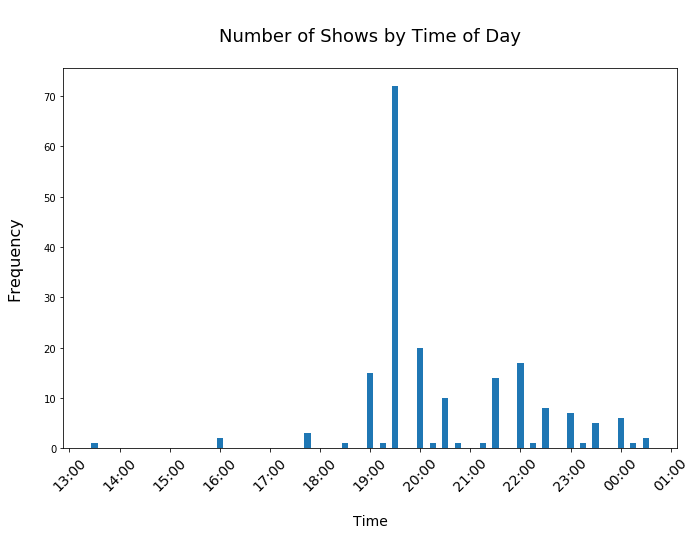

In [17]:
df_plot.plot(kind = 'bar', figsize = (11, 7), legend = False)

plt.xticks(range(0, len(df_plot.index), 4), df_plot.index[::4], rotation=45, fontsize=14)
plt.xlabel('\nTime', fontsize=14)
plt.ylabel('Frequency\n', fontsize=16)
plt.title("\nNumber of Shows by Time of Day\n", fontsize=18)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.show()

Shows are scheduled at 15 minute intervals, and overall 7:30 pm is by far the most popular show time, and most other shows occur after this time.

### Number of shows by location

In [18]:
res = list(coll.aggregate([
        {'$group': {'_id': '$location',
                    'count': {'$sum': 1}}},
        {'$sort': {'count': 1}}
]))

for r in res:
    pprint(r)

{'_id': 'Comedy Cellar - Village Underground', 'count': 11}
{'_id': 'Comedy Cellar - Fat Black Pussycat Lounge', 'count': 22}
{'_id': 'Comedy Cellar - MacDougal Street', 'count': 26}
{'_id': 'The Stand NYC', 'count': 40}
{'_id': 'Carolines', 'count': 91}


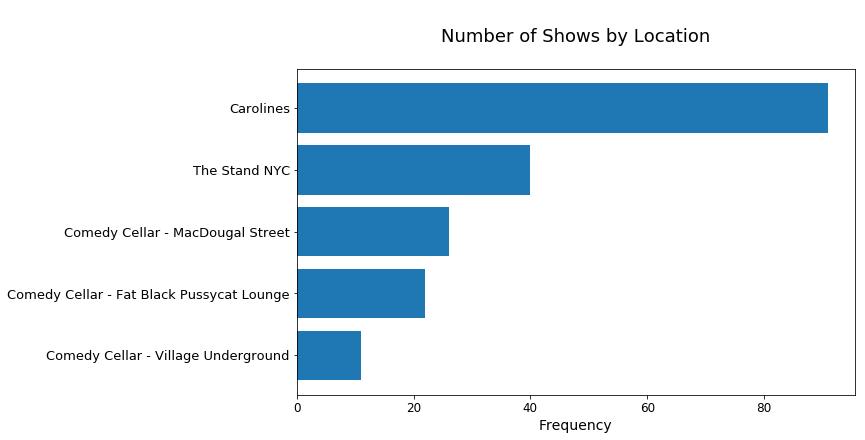

In [19]:
locs = []
counts = []
for r in res:
    locs.append(r['_id'])
    counts.append(r['count'])
    
fig, ax  = plt.subplots(1, 1, figsize = (10,6))

plt.barh(range(len(locs)), counts)
plt.yticks(range(len(locs)), locs)
plt.xlabel('Frequency', fontsize=14)
plt.title("\nNumber of Shows by Location\n", fontsize=18)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=13)

plt.show()

### Average number of shows per night at each location

In [20]:
res = list(coll.aggregate([
        {'$group': {'_id': {'location': '$location',
                            'date': '$date'},
                    'count': {'$sum': 1}}},
        {'$group': {'_id': {'location': '$_id.location'},
                    'avg': {'$avg': '$count'}}},
        {'$sort': {'avg': -1}}
]))

for r in res:
    pprint(r)

{'_id': {'location': 'Comedy Cellar - MacDougal Street'},
 'avg': 3.7142857142857144}
{'_id': {'location': 'The Stand NYC'}, 'avg': 2.2222222222222223}
{'_id': {'location': 'Comedy Cellar - Village Underground'}, 'avg': 2.2}
{'_id': {'location': 'Comedy Cellar - Fat Black Pussycat Lounge'},
 'avg': 1.8333333333333333}
{'_id': {'location': 'Carolines'}, 'avg': 1.1973684210526316}


### Most expensive tickets

In [21]:
query = {'price' : {'$exists': 1}}
projection = {'_id': 0, 'price': 1, 'date_str': 1}

for doc in list(coll.find(query, projection).sort('price', pymongo.DESCENDING))[:10]:
    print(doc)

{'price': 155.0, 'date_str': 'December 31, 2017'}
{'price': 145.0, 'date_str': 'December 31, 2017'}
{'date_str': 'January 25, 2018', 'price': 53.0}
{'date_str': 'January 26, 2018', 'price': 53.0}
{'date_str': 'January 28, 2018', 'price': 53.0}
{'date_str': 'February 8, 2018', 'price': 49.0}
{'date_str': 'February 9, 2018', 'price': 49.0}
{'date_str': 'February 10, 2018', 'price': 49.0}
{'date_str': 'February 11, 2018', 'price': 49.0}
{'date_str': 'April 14, 2018', 'price': 49.0}


The most expensive shows, by far, are those occurring on December 31 (New Year's Eve).  Most restaurants, clubs, etc. charge a premium for events occuring on this night.

### Number of shows by ticket price

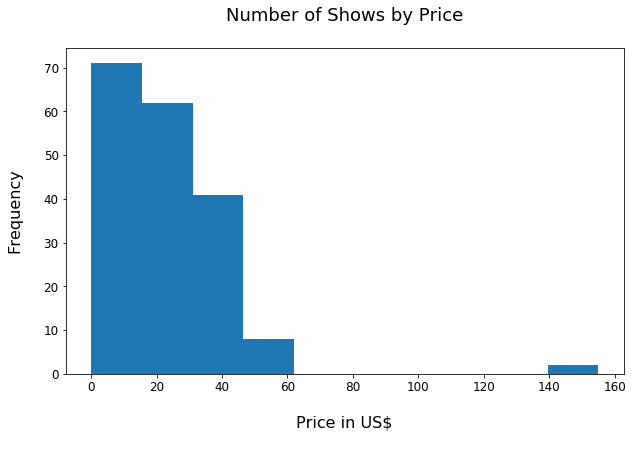

In [22]:
prices = []
for s in coll.find(query, projection):
    prices.append(s['price'])

fig, ax  = plt.subplots(1, 1, figsize = (10,6))

plt.hist(prices)
plt.xlabel('\nPrice in US$\n', fontsize=16)
plt.ylabel('Frequency\n', fontsize=16)
plt.title('Number of Shows by Price\n', fontsize=18)

plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)

plt.show()

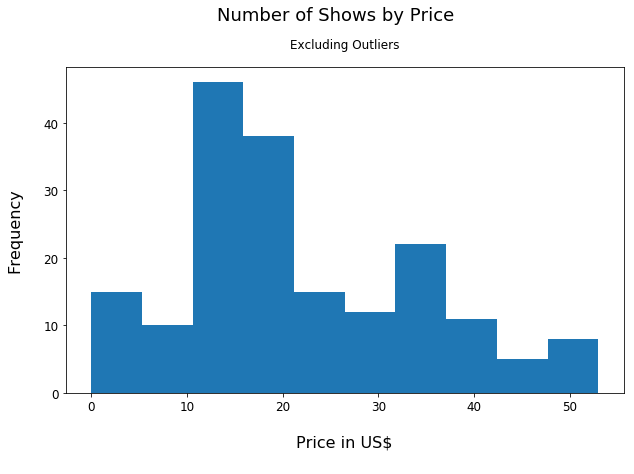

In [23]:
fig, ax  = plt.subplots(1, 1, figsize = (10,6))

plt.hist([p for p in prices if p < 80])
plt.xlabel('\nPrice in US$\n', fontsize=16)
plt.ylabel('Frequency\n', fontsize=16)
plt.suptitle('Number of Shows by Price\n', y=1.02, fontsize=18)
plt.title('\nExcluding Outliers', y=1.04, fontsize=12)

plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)

plt.show()

### Ticket prices by location

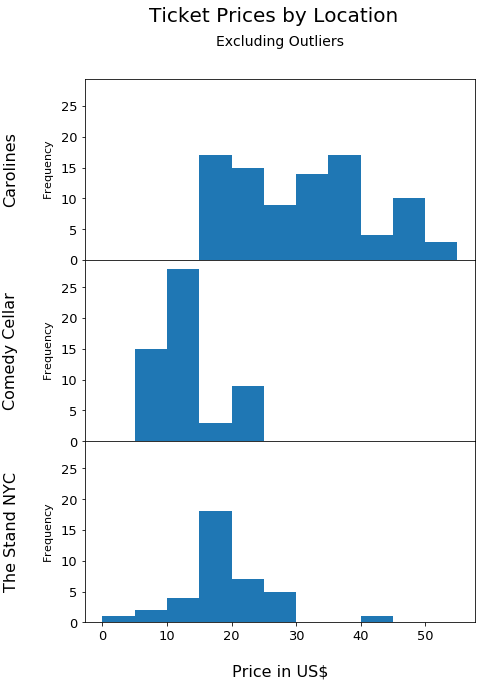

In [24]:
query = {'price' : {'$exists': 1}, 'location': 'The Stand NYC'}
projection = {'_id': 0, 'price': 1}
docs = list(coll.find(query, projection).sort('price', pymongo.DESCENDING))
stand_prices = [docs['price'] for docs in docs if docs['price'] < 80]

query = {'price' : {'$exists': 1}, 'location': 'Carolines'}
projection = {'_id': 0, 'price': 1}
docs = list(coll.find(query, projection).sort('price', pymongo.DESCENDING))
carolines_prices = [docs['price'] for docs in docs ]

query = {'price' : {'$exists': 1}, 'location': {'$regex': 'Comedy Cellar'}}
projection = {'_id': 0, 'price': 1}
docs = list(coll.find(query, projection).sort('price', pymongo.DESCENDING))
cellar_prices = [docs['price'] for docs in docs if docs['price'] < 80]

# Histograms of the ticket prices by location
fig, (ax1, ax2, ax3)  = plt.subplots(3, 1, sharex = True, sharey = True, figsize = (7,10))

# Carolines
ax1 = plt.subplot(311)
bins = list(range(0, 60, 5))
plt.hist(carolines_prices, bins=bins)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1.get_yticklabels(), fontsize=13)
plt.ylabel('Carolines\n\n$\\regular_{Frequency}$', fontsize=16)
plt.suptitle('Ticket Prices by Location', fontsize=20)
plt.title('Excluding Outliers', y=1.15, fontsize=14)

# Comedy Cellar
ax2 = plt.subplot(312, sharex=ax1, sharey=ax1)
plt.hist(cellar_prices, bins=bins)
plt.setp(ax2.get_xticklabels(), fontsize=13)
plt.setp(ax2.get_yticklabels(), fontsize=13)
plt.ylabel('Comedy Cellar\n\n$\\regular_{Frequency}$', fontsize=16)

# The Stand NYC
ax3 = plt.subplot(313, sharex=ax1, sharey=ax1)
plt.hist(stand_prices, bins=bins)
plt.setp(ax3.get_xticklabels(), fontsize=13)
plt.setp(ax3.get_yticklabels(), fontsize=13)
plt.ylabel('The Stand NYC\n\n$\\regular_{Frequency}$', fontsize=16)
plt.xlabel('\nPrice in US$', fontsize=16)
plt.subplots_adjust(hspace=0)

plt.show()

The Comedy Cellar's shows have a much smaller range for ticket prices with a similar median to that of The Stand.  They both also have very clear modes, where as Carolines' spread of prices is much more uniform.   In general, Carolines's ticket prices are more expensive than those of the other two locations.

### Correct performer names

There were two performers' names that were not expressed consistently in the data.  The first is Big Jay Oakerson.  He is mostly known by this moniker, but he was also included as Jay Oakerson.  I updated all appearances of this shortened name to the longer version.

Additionally, sometimes Roy Wood, Jr. was included in the data without a comma or period, or with junior in lowercase.  These were corrected to Roy Wood, Jr.

In [25]:
query = {'acts.name' : 'Jay Oakerson'}
projection = {'_id': 0, 'acts.$.name': 1}
for c in coll.find(query, projection):
    pprint(c)

{'acts': [{'name': 'Jay Oakerson', 'type': 'performer'}]}
{'acts': [{'name': 'Jay Oakerson', 'type': 'performer'}]}


In [26]:
coll.update_many({'acts.name': 'Jay Oakerson'},
                 {'$set': {'acts.$.name': 'Big Jay Oakerson'}})
    
query = {'acts.name' : {'$regex': 'Jay Oakerson'}}
projection = {'_id': 0, 'acts.$.name': 1}
for c in coll.find(query, projection):
    pprint(c)

{'acts': [{'name': 'Big Jay Oakerson', 'type': 'performer'}]}
{'acts': [{'name': 'Big Jay Oakerson', 'type': 'performer'}]}
{'acts': [{'name': 'Big Jay Oakerson', 'type': 'performer'}]}
{'acts': [{'name': 'Big Jay Oakerson', 'type': 'performer'}]}
{'acts': [{'name': 'Big Jay Oakerson', 'type': 'performer'}]}
{'acts': [{'name': 'Big Jay Oakerson', 'type': 'performer'}]}
{'acts': [{'name': 'Big Jay Oakerson', 'type': 'performer'}]}
{'acts': [{'name': 'Big Jay Oakerson', 'type': 'performer'}]}
{'acts': [{'name': 'Big Jay Oakerson', 'type': 'performer'}]}
{'acts': [{'name': 'Big Jay Oakerson', 'type': 'performer'}]}
{'acts': [{'name': 'Big Jay Oakerson', 'type': 'performer'}]}
{'acts': [{'name': 'Big Jay Oakerson', 'type': 'performer'}]}
{'acts': [{'name': 'Big Jay Oakerson', 'type': 'performer'}]}
{'acts': [{'name': 'Big Jay Oakerson', 'type': 'performer'}]}


In [27]:
query = {'acts.name': {'$regex': 'Wood'}}
projection = {'_id': 0, 'acts.$.name': 1}

for c in coll.find(query, projection):
    pprint(c)

{'acts': [{'name': 'Tony Woods', 'type': 'performer'}]}
{'acts': [{'name': 'Tony Woods', 'type': 'performer'}]}
{'acts': [{'name': 'Roy Wood jr', 'type': 'performer'}]}
{'acts': [{'name': 'Roy Wood jr', 'type': 'performer'}]}
{'acts': [{'name': 'Roy Wood jr', 'type': 'performer'}]}
{'acts': [{'name': 'Roy Wood jr', 'type': 'performer'}]}
{'acts': [{'name': 'Roy Wood jr', 'type': 'performer'}]}
{'acts': [{'name': 'Roy Wood jr', 'type': 'performer'}]}
{'acts': [{'name': 'Roy Wood, Jr.', 'type': 'performer'}]}


In [28]:
coll.update_many({'acts.name': 'Roy Wood jr'},
                 {'$set': {'acts.$.name': 'Roy Wood, Jr.'}})

query = {'acts.name': {'$regex': 'Wood'}}
projection = {'_id': 0, 'acts.$.name': 1}

for c in coll.find(query, projection):
    pprint(c)

{'acts': [{'name': 'Tony Woods', 'type': 'performer'}]}
{'acts': [{'name': 'Tony Woods', 'type': 'performer'}]}
{'acts': [{'name': 'Roy Wood, Jr.', 'type': 'performer'}]}
{'acts': [{'name': 'Roy Wood, Jr.', 'type': 'performer'}]}
{'acts': [{'name': 'Roy Wood, Jr.', 'type': 'performer'}]}
{'acts': [{'name': 'Roy Wood, Jr.', 'type': 'performer'}]}
{'acts': [{'name': 'Roy Wood, Jr.', 'type': 'performer'}]}
{'acts': [{'name': 'Roy Wood, Jr.', 'type': 'performer'}]}
{'acts': [{'name': 'Roy Wood, Jr.', 'type': 'performer'}]}


### Number of shows with no acts

In [29]:
coll.find({'acts' : {'$exists': 0}}).count()

11

### Number of shows with only one act

In [30]:
coll.find({'acts': {'$size': 1}}).count()

91

### Top ten performers by number of shows

In [31]:
res = coll.aggregate([
        {'$unwind': '$acts'},
        {'$group': {'_id': '$acts.name',
                    'count': {'$sum': 1}}},
        {'$sort': {'count': -1}},
        {'$limit': 10}
])

for r in res:
    pprint(r)

{'_id': 'Ari Shaffir', 'count': 24}
{'_id': 'Vladimir Caamano', 'count': 15}
{'_id': 'Big Jay Oakerson', 'count': 14}
{'_id': 'Jessica Kirson', 'count': 12}
{'_id': 'Mike Vecchione', 'count': 11}
{'_id': 'Aaron Berg', 'count': 10}
{'_id': 'Michelle Wolf', 'count': 10}
{'_id': 'Keith Robinson', 'count': 9}
{'_id': 'Dan St. Germain', 'count': 9}
{'_id': 'Laurie Kilmartin', 'count': 9}


### Number of unique performers

In [32]:
len(coll.distinct('acts.name'))

215

### Number of unique performers by location

In [33]:
res = coll.aggregate([
        {'$unwind': '$acts'},
        {'$group': {'_id': '$location',
                    'unique_acts': {'$addToSet': '$acts.name'}}},
        {'$project': {'_id': 1,
                      'num_unique_acts': {'$size': '$unique_acts'}}},
        {'$sort': {'num_unique_acts': -1}}
])
                      
for r in res:
    pprint(r)

{'_id': 'Carolines', 'num_unique_acts': 102}
{'_id': 'Comedy Cellar - MacDougal Street', 'num_unique_acts': 68}
{'_id': 'The Stand NYC', 'num_unique_acts': 51}
{'_id': 'Comedy Cellar - Village Underground', 'num_unique_acts': 50}
{'_id': 'Comedy Cellar - Fat Black Pussycat Lounge', 'num_unique_acts': 25}


### Acts that appear at least three clubs

In [34]:
res = coll.aggregate([
        {'$unwind': '$acts'},
        {'$group': {'_id': '$acts.name',
                    'clubs': {'$addToSet': '$location'}}},
        {'$project': {'_id': 1,
                      'num_clubs': {'$size': '$clubs'}}},
        {'$match': {'num_clubs': {'$gte': 3}}},
        {'$sort': {'num_clubs': -1}}
])
                      
for r in res:
    pprint(r)

{'_id': 'Rachel Feinstein', 'num_clubs': 4}
{'_id': 'Chris Distefano', 'num_clubs': 4}
{'_id': 'Jessica Kirson', 'num_clubs': 4}
{'_id': 'Nathan Macintosh', 'num_clubs': 3}
{'_id': 'Judah Friedlander', 'num_clubs': 3}
{'_id': 'Lynne Koplitz', 'num_clubs': 3}
{'_id': 'Joe List', 'num_clubs': 3}
{'_id': 'Ryan Hamilton', 'num_clubs': 3}
{'_id': 'Ricky Velez', 'num_clubs': 3}
{'_id': 'Big Jay Oakerson', 'num_clubs': 3}
{'_id': 'Michelle Wolf', 'num_clubs': 3}
{'_id': 'Liz Miele', 'num_clubs': 3}
{'_id': 'Ari Shaffir', 'num_clubs': 3}
{'_id': 'Carmen Lynch', 'num_clubs': 3}
{'_id': 'Jared Freid', 'num_clubs': 3}
{'_id': 'Roy Wood, Jr.', 'num_clubs': 3}
{'_id': 'Lenny Marcus', 'num_clubs': 3}
{'_id': 'Dov Davidoff', 'num_clubs': 3}
{'_id': 'Des Bishop', 'num_clubs': 3}
{'_id': 'Mike Yard', 'num_clubs': 3}
{'_id': 'Ryan Reiss', 'num_clubs': 3}


### Performers with the greatest number of appearances as MC

In [35]:
res = coll.aggregate([
        {'$unwind': '$acts'},
        {'$match': {'acts.type': 'MC'}},
        {'$group': {'_id': '$acts.name',
                    'count': {'$sum': 1}}},
        {'$sort': {'count': -1}},
        {'$limit': 10}
])

for r in res:
    pprint(r)

{'_id': 'Wil Sylvince', 'count': 7}
{'_id': 'Mike Yard', 'count': 6}
{'_id': 'Hasan Minhaj', 'count': 6}
{'_id': 'William Stephenson', 'count': 4}
{'_id': 'Ryan Reiss', 'count': 4}
{'_id': 'Jared Freid', 'count': 3}
{'_id': 'Seaton C. Smith', 'count': 3}
{'_id': 'Mike Finoia', 'count': 3}
{'_id': 'Ardie Fuqua', 'count': 3}
{'_id': 'Lynne Koplitz', 'count': 2}


### Acts by the highest average ticket price (excluding outliers)

In [36]:
res = coll.aggregate([
        {'$unwind': '$acts'},
        {'$match': {'price' : {'$lt': 80}}},
        {'$group': {'_id': '$acts.name',
                    'average_price': {'$avg': '$price'}}},
        {'$sort': {'average_price': -1}},
        {'$limit': 10}
])

for r in res:
    pprint(r)

{'_id': 'JB Smoove', 'average_price': 53.0}
{'_id': 'Jeff Ross', 'average_price': 49.0}
{'_id': 'Corey Holcomb', 'average_price': 46.833333333333336}
{'_id': 'Sinbad', 'average_price': 45.75}
{'_id': 'Donnell Rawlings', 'average_price': 41.0}
{'_id': 'Aida Rodriguez', 'average_price': 40.0}
{'_id': 'Jim Florentine', 'average_price': 40.0}
{'_id': 'Aligon Mitra', 'average_price': 38.25}
{'_id': 'Kerry Coddett', 'average_price': 38.25}
{'_id': 'Francis Ellis', 'average_price': 38.25}


### Number of shows by Daily Show correspondents or contributors

In [37]:
ds_corr_contrib = ['Ronny Chieng', 'Hasan Minhaj', 'Roy Wood, Jr.',
                   'Desi Lydic', 'Michael Kosta', 'Dulce Sloan',
                   'Lewis Black', 'Neal Brennan', 'Michelle Wolf',
                   'Gina Yashere']

res = coll.aggregate([
        {'$unwind': '$acts'},
        {'$match': {'acts.name': {'$in': ds_corr_contrib}}},
        {'$group': {'_id': '$acts.name',
                    'count': {'$sum': 1}}},
        {'$sort': {'count': -1}}
])
         
for r in res:
    pprint(r)

{'_id': 'Michelle Wolf', 'count': 10}
{'_id': 'Roy Wood, Jr.', 'count': 7}
{'_id': 'Hasan Minhaj', 'count': 6}
{'_id': 'Dulce Sloan', 'count': 1}
{'_id': 'Ronny Chieng', 'count': 1}
